### Prep dataset

In [1]:
#!pip install requirements.txt 

In [1]:
import pathlib, os
data_path = pathlib.Path("data/")
image_path = data_path / "ProcessedEmotionDataset/Images"


if data_path.is_dir():
    data_path.mkdir(parents=True, exist_ok=True)
if image_path.is_dir():
    print(f"{image_path} exists... skipping creation")
else: 
    print(f"{image_path} doesn't exits.. creating one")
    image_path.mkdir(parents=True, exist_ok=True)

def class_info(dir_path):
    class_dirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    for idx, class_name in enumerate(class_dirs):
        print(f'{idx}: "{class_name}",')

class_info(image_path)

data\ProcessedEmotionDataset\Images exists... skipping creation
0: "Anger",
1: "Contempt",
2: "Disgust",
3: "Fear",
4: "Happy",
5: "Neutral",
6: "Sad",
7: "Surprised",


In [1]:
CLASS_LABEL={
    0: "Anger",
    1: "Contempt",
    2: "Disgust",
    3: "Fear",
    4: "Happy",
    5: "Neutral",
    6: "Sad",
    7: "Surprised"
}

In [23]:
BATCH_SIZE=128
TEST_BATCH_SIZE=32
IMG_SIZE=(224, 224)

In [3]:
import zipfile
import pathlib
import os
from PIL import Image
import random
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

### 0. DATA PREP

In [4]:
data_path=pathlib.Path("data/")
image_path=data_path/"ProcessedEmotionDataset/Images"

In [ ]:
# for split dataset folder

if pathlib.Path(data_path/"ProcessedEmotionDataset").is_dir():
    print(f"{data_path/"ProcessedEmotionDataset"} exists... skipping creation")
else: 
    print(f"{image_path} doesn't exits.. creating one")
    pathlib.Path(data_path/"ProcessedEmotionDataset").mkdir(parents=True, exist_ok=True)

if len(os.listdir(aux_path)) == 0:
    if data_path.exists():
        with zipfile.ZipFile(data_path / "archive.zip", "r") as zip_asset:
            print("Unzipping data...")
            zip_asset.extractall(data_path)
            print("Done!")
    else:
        print(f"""{data_path / 'archive.zip'} does not exist, please check the path or download it""")
else:
    print(f"{str(image_path)} is not empty, skipping unzipping")


data\ProcessedEmotionDataset exists... skipping creation
data\ProcessedEmotionDataset\Images is not empty, skipping unzipping


In [ ]:
def data_folder_info(dir_path):
    for dirpath, dirname, filename in os.walk(dir_path):
        print(f"{dirpath} has {len(dirname)} directory and {len(filename)} files")
data_folder_info(image_path)

data\ProcessedEmotionDataset\Images has 8 directory and 0 files
data\ProcessedEmotionDataset\Images\Anger has 0 directory and 5519 files
data\ProcessedEmotionDataset\Images\Contempt has 0 directory and 4269 files
data\ProcessedEmotionDataset\Images\Disgust has 0 directory and 4322 files
data\ProcessedEmotionDataset\Images\Fear has 0 directory and 5519 files
data\ProcessedEmotionDataset\Images\Happy has 0 directory and 5519 files
data\ProcessedEmotionDataset\Images\Neutral has 0 directory and 5519 files
data\ProcessedEmotionDataset\Images\Sad has 0 directory and 5519 files
data\ProcessedEmotionDataset\Images\Surprised has 0 directory and 5519 files


In [7]:
image_list=list(image_path.glob("**/*.[pj]*g"))
print(f"Total {len(image_list)} images found in {image_path}")
# image_list=list(train_path.glob("**/*.jpg"))
# print(f"Total {len(image_list)} images found in {train_path}")
# image_list=list(test_path.glob("**/*.jpg"))
# print(f"Total {len(image_list)} images found in {test_path}")

Total 41705 images found in data\ProcessedEmotionDataset\Images


Image class: Disgust
Image width: 156, height: 156, format: JPEG
Image size: (156, 156), mode: RGB


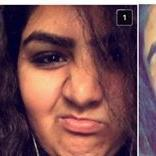

In [8]:
img_random=image_list[random.choice(range(len(image_list)))]
img=Image.open(img_random)
img_class=img_random.parent.stem
print(f"Image class: {img_class}")
print(f"Image width: {img.width}, height: {img.height}, format: {img.format}")
print(f"Image size: {img.size}, mode: {img.mode}")
img

In [5]:
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    ])

In [6]:
dataset= datasets.ImageFolder(
    root=image_path,
    transform=data_transforms,
    target_transform=None
)   

In [26]:
total_size = len(dataset)
total_size
train_ratio = 0.1
val_ratio = 0.02
test_ratio = 0.02
leftover = 1 - (train_ratio + val_ratio + test_ratio)

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = int(test_ratio * total_size)
leftover_size = total_size - (train_size + val_size + test_size)

seed =random.seed(42)
train_dataset, val_dataset, test_dataset, leftover_dataset = random_split(dataset, [train_size, val_size, test_size, leftover_size], generator=seed)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# leftover_loader = DataLoader(leftover_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 1. Create model

In [9]:
import torchvision.models as models

def get_resnet34(num_classes=len(CLASS_LABEL), in_channels=3, pretrained=True):
    # Load pretrained ResNet34
    model = models.resnet34(pretrained=pretrained)

    # Modify the first conv layer to accept 1 channel instead of 3
    if in_channels == 1:
        # Old conv1 expects 3 channels: [64, 3, 7, 7]
        weight = model.conv1.weight.data
        model.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        # Initialize with mean of pretrained weights
        model.conv1.weight.data = weight.mean(dim=1, keepdim=True)

    # Modify the fully connected layer for your number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

model = get_resnet34(num_classes=len(CLASS_LABEL), in_channels=3, pretrained=False)


c:\Users\admin\.conda\envs\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\.conda\envs\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### 2.Train model


In [17]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
def train_one_epoch(epoch_index, tb_writer, training_loader, model, optimizer, loss_fn):
    running_loss = 0.0
    last_loss = 0.0
    correct=0
    total = 0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        #loss
        running_loss += loss.item()
        #accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

            

    epoch_loss = running_loss / len(training_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [19]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [20]:
def train_model(model, train_loader,  optimizer, loss_fn, file_name, log_file, runner_name, epochs=10):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/{}_trainer_{}'.format(runner_name,timestamp))
    epoch_number = 0

    best_loss = 1_000_000.
    best_acc = 0.

    filename=log_file
    history = {
        "train_loss": [],
        "train_acc": [],
    }
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        train_loss, train_acc = train_one_epoch(epoch_index=epoch_number, 
                                tb_writer=writer,
                                training_loader=train_loader, 
                                model=model,
                                optimizer=optimizer,
                                loss_fn=loss_fn)

        # Log the running loss averaged per batch
        # for both training and validation
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        writer.add_scalars("Loss", {"train":train_loss}, epoch_number + 1)
        writer.add_scalars("Accuracy", {"train": train_acc}, epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if train_loss < best_loss and train_acc > best_acc:
            best_loss =train_loss
            torch.save({
                "epoch": epoch_number,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "history": history 
            }, f"{file_name}_best_{timestamp}.pth")

            print(f"Checkpoint saved at epoch {epoch+14} → {timestamp}.pth")
        else:
            torch.save({
                "epoch": epoch_number,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "history": history   # save training history
            }, f"{file_name}_not_best_{timestamp}.pth")

            print(f"Checkpoint saved at epoch {epoch+1} → {file_name}_{timestamp}.pth")

        log_file = open(filename, "a")
        log_line = f"""Epoch [{epoch+14}]: "train_loss": {train_loss},
            "train_acc": {train_acc}\n"""
        log_file.write(log_line)        
        log_file.flush()
        log_file.close()

        epoch_number += 1

    return model, history

In [12]:
checkpoint = torch.load('./res224colored_transfer_b2_best_20250903_092840.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [13]:
checkpoint['history']

{'train_loss': [1.3350126851688733,
  1.0146568002122822,
  0.7657594427917943,
  0.5717894434928894,
  0.4085767124638413,
  0.28628274391997943,
  0.19561537332607037],
 'train_acc': [0.5201438848920863,
  0.6458033573141487,
  0.7654676258992805,
  0.8458033573141487,
  0.9086330935251798,
  0.9539568345323741,
  0.9774580335731415]}

In [ ]:
cancel

In [ ]:
# i seperate the training to another func for easly testing other parameters
model, history=train_model(model, train_loader, optimizer, loss_fn, 
                           file_name="res224colored_transfer_b2", 
                           log_file="log_res224colored_transfer_b2.txt", 
                           runner_name="fer224colored_b2",
                           epochs=10)


EPOCH 1:
Checkpoint saved at epoch 14 → 20250903_092840.pth
EPOCH 2:
Checkpoint saved at epoch 15 → 20250903_092840.pth
EPOCH 3:
Checkpoint saved at epoch 16 → 20250903_092840.pth
EPOCH 4:
Checkpoint saved at epoch 17 → 20250903_092840.pth
EPOCH 5:
Checkpoint saved at epoch 18 → 20250903_092840.pth
EPOCH 6:
Checkpoint saved at epoch 19 → 20250903_092840.pth
EPOCH 7:
Checkpoint saved at epoch 20 → 20250903_092840.pth
EPOCH 8:


In [ ]:
stop

In [14]:
log_file = "./log.txt"

train_loss = []
train_acc = []

with open(log_file, "r") as f:
    lines = [line.strip() for line in f if line.strip()]  # remove empty lines

    # process every 2 lines as one record
    for i in range(0, len(lines), 2):
        line1 = lines[i]
        line2 = lines[i+1]

        # loss is in line1
        loss_str = line1.split(":")[-1].replace(",", "").strip()
        loss = float(loss_str)

        # acc is in line2
        acc_str = line2.split(":")[-1].strip()
        acc = float(acc_str)

        train_loss.append(loss)
        train_acc.append(acc)

history = {
    "train_loss": train_loss,
    "train_acc": train_acc
}

print(history)


{'train_loss': [2.0325174729029336, 1.7937280156395652, 1.5990519740364768, 1.4168797225663157, 1.2433066548723164, 1.5858547126545626, 1.4685305216733147, 1.3479379555758308, 1.4671977216547185, 1.2576878395947544, 1.0658291668602915, 0.8930718609780977, 0.725614500768257, 1.3350126851688733, 1.0146568002122822, 0.7657594427917943, 0.5717894434928894, 0.4085767124638413, 0.28628274391997943, 0.19561537332607037], 'train_acc': [0.2038369304556355, 0.33189448441247005, 0.4378896882494005, 0.5057553956834533, 0.5822541966426859, 0.40959232613908875, 0.4565947242206235, 0.5175059952038369, 0.4551558752997602, 0.5419664268585132, 0.6314148681055156, 0.7124700239808154, 0.7853717026378897, 0.5201438848920863, 0.6458033573141487, 0.7654676258992805, 0.8458033573141487, 0.9086330935251798, 0.9539568345323741, 0.9774580335731415]}


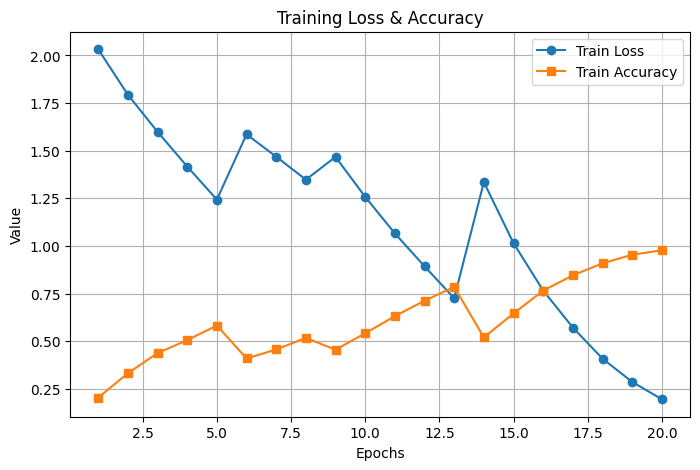

In [15]:
import matplotlib.pyplot as plt

results = history
epochs = range(1, len(results['train_loss']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, results['train_loss'], label="Train Loss", marker='o')
plt.plot(epochs, results['train_acc'], label="Train Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Loss & Accuracy")
plt.legend()
plt.grid(True)
plt.show()


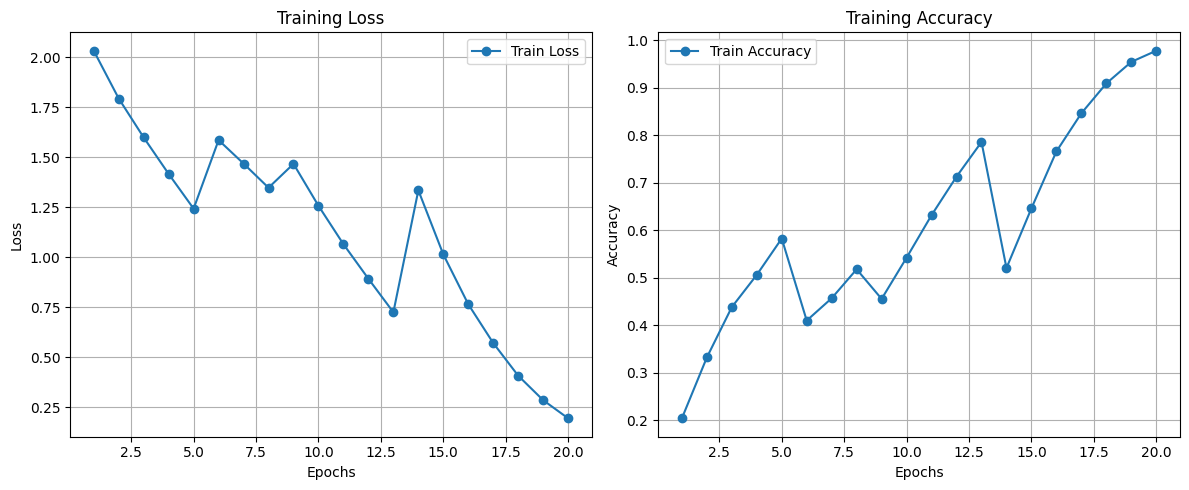

In [16]:
import matplotlib.pyplot as plt

results=history
epochs = range(1, len(results['train_loss']) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['train_loss'], label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, results['train_acc'], label="Train Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3. Load model

In [ ]:
checkpoint = torch.load('', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
img=Image.open('./test/518272026_1276915794036753_300975629328033224_n.jpg')
img=data_transforms(img)
img=img.unsqueeze(0) 

output = model(img)
pred = torch.argmax(output, dim=1)
print(CLASS_LABEL[pred.item()])

Neutral


### 4. Testing

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   class_names: list,
                   device: str = "cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification report (precision, recall, f1 for each class)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return report, cm

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns  # makes heatmap nicer

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:
               precision    recall  f1-score   support

       Anger     0.4521    0.6055    0.5176       109
    Contempt     0.4545    0.4118    0.4321        85
     Disgust     0.5221    0.6277    0.5700        94
        Fear     0.6625    0.4690    0.5492       113
       Happy     0.6096    0.8165    0.6980       109
     Neutral     0.3889    0.5000    0.4375        98
         Sad     0.5316    0.3652    0.4330       115
   Surprised     0.6866    0.4144    0.5169       111

    accuracy                         0.5264       834
   macro avg     0.5385    0.5263    0.5193       834
weighted avg     0.5441    0.5264    0.5215       834



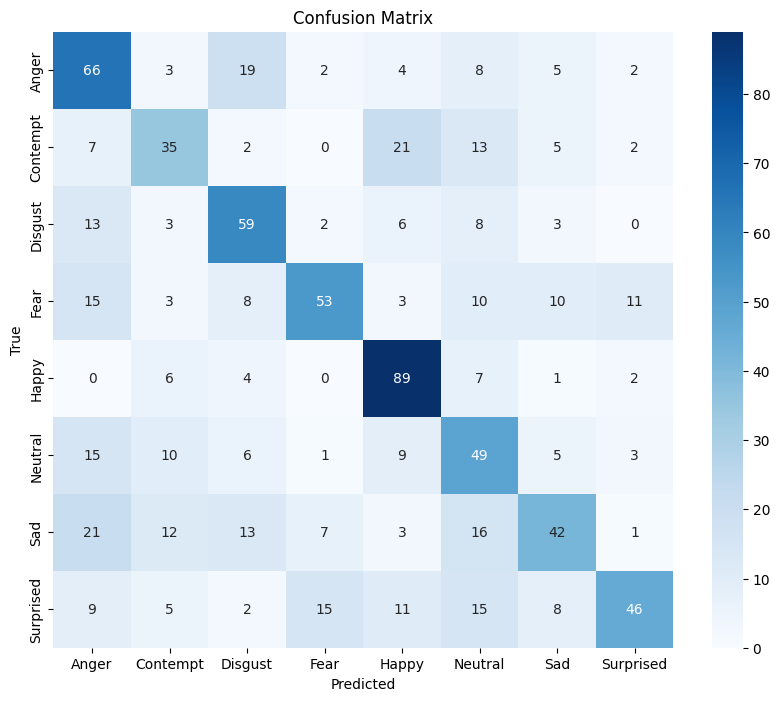

In [28]:
report, cm = evaluate_model(model, test_loader, class_names=list(CLASS_LABEL.values()))

print("Classification Report:\n", report)
plot_confusion_matrix(cm, list(CLASS_LABEL.values()))
